In [95]:
# Bonus: Predictive Modeling on Trader Profitability

In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [97]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

In [98]:
# sentiment date
sentiment['date'] = pd.to_datetime(sentiment['timestamp']).dt.date

# trades date
trades['date'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    format='mixed'
).dt.date

In [140]:
merged = pd.merge(trades,sentiment,on='date',how='left')

In [144]:
merged['classification'] = merged['classification'].fillna('Neutral')


In [146]:
data = (
    merged
    .groupby(['Account','date'])
    .agg(
        trades_count=('Account','count'),
        avg_position_size=('Size USD','mean'),
        sentiment=('classification','first'),
        Closed_PnL=('Closed PnL','sum')
    )
    .reset_index()
)

print("Data rows:", len(data))
data.head()

Data rows: 2341


,Account,date,trades_count,avg_position_size,sentiment,Closed_PnL
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,177,5089.718249,Neutral,0.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,68,7976.664412,Neutral,0.0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,40,23734.500000,Neutral,0.0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,12,28186.666667,Neutral,-21227.0
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,27,17248.148148,Neutral,1603.1


In [100]:
daily_pnl = (
    merged
    .groupby(['Account','date'])['Closed PnL']
    .sum()
    .reset_index()
)

In [101]:
features = (
    merged
    .groupby(['Account','date'])
    .agg(
        trades_count=('Account','count'),
        avg_position_size=('Size USD','mean'),
        sentiment=('classification','first')
    )
    .reset_index()
)

In [103]:
features['date'] = pd.to_datetime(features['date']).dt.date
daily_pnl['date'] = pd.to_datetime(daily_pnl['date']).dt.date

In [136]:
data = (
    merged
    .groupby(['Account','date'])
    .agg(
        trades_count=('Account','count'),
        avg_position_size=('Size USD','mean'),
        sentiment=('classification','first'),
        Closed_PnL=('Closed PnL','sum')
    )
    .reset_index()
)

print("Data rows:", len(data))
data.head()


Data rows: 0


,Account,date,trades_count,avg_position_size,sentiment,Closed_PnL


In [138]:
print("Trades rows:", len(trades))
print("Sentiment rows:", len(sentiment))
print("Merged rows:", len(merged))

merged.head()

Trades rows: 211224
Sentiment rows: 2644
Merged rows: 0


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,timestamp,value,classification


In [148]:
data['profitable_today'] = (data['Closed_PnL'] > 0).astype(int)

In [150]:
data['sentiment_binary'] = np.where(
    data['sentiment'].str.contains('Fear', case=False),
    0,
    1
)

In [152]:
X = data[['trades_count', 'avg_position_size', 'sentiment_binary']]
y = data['profitable_today']

print("Positive class ratio:", y.mean())


Positive class ratio: 0.6266552755232806


In [154]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

In [156]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [158]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6173541963015647
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       268
           1       0.62      1.00      0.76       435

    accuracy                           0.62       703
   macro avg       0.31      0.50      0.38       703
weighted avg       0.38      0.62      0.47       703



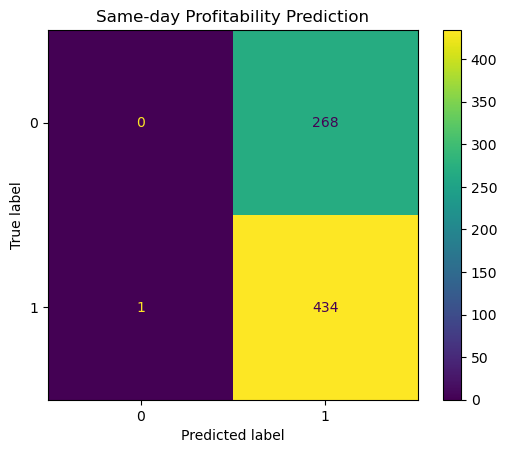

In [160]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Same-day Profitability Prediction")
plt.show()